In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as knc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Data Preprossesing

reading the data

In [2]:
training_data = pd.read_csv('train.csv')

#exploring the data 
print(training_data.shape)

print(training_data.info())

print(training_data.isna().sum())
print(training_data.columns)

(891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Survived     891 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Survived         0
d

# conclusion
 the number of missing values in age is not that big so we can fill these values with the mean \
 the number of missing values in cabin is more than 50% -->col. will be droped \
 the two missing values in Embarked column will be droped \
 ticket & name is uniqu so there is no point of having them --> col.s will be droped


In [3]:
#calculating the mean 
mean_of_age = training_data['Age'].mean()

#filling the Age column with the mean
training_data['Age'] = training_data['Age'].fillna(mean_of_age)

#droping the Cabin, name and ticket col
training_data = training_data.drop(['PassengerId','Cabin','Name','Ticket'],axis=1)

#droping the missng rows
training_data = training_data.dropna()

print(training_data.shape)
print(training_data.head(10))


(889, 8)
   Pclass     Sex        Age  SibSp  Parch     Fare Embarked  Survived
0       3    male  22.000000      1      0   7.2500        S         0
1       1  female  38.000000      1      0  71.2833        C         1
2       3  female  26.000000      0      0   7.9250        S         1
3       1  female  35.000000      1      0  53.1000        S         1
4       3    male  35.000000      0      0   8.0500        S         0
5       3    male  29.699118      0      0   8.4583        Q         0
6       1    male  54.000000      0      0  51.8625        S         0
7       3    male   2.000000      3      1  21.0750        S         0
8       3  female  27.000000      0      2  11.1333        S         1
9       2  female  14.000000      1      0  30.0708        C         1


is there any outlier in this data ? --> only one way to find out \
we will plot the data do find any outlier

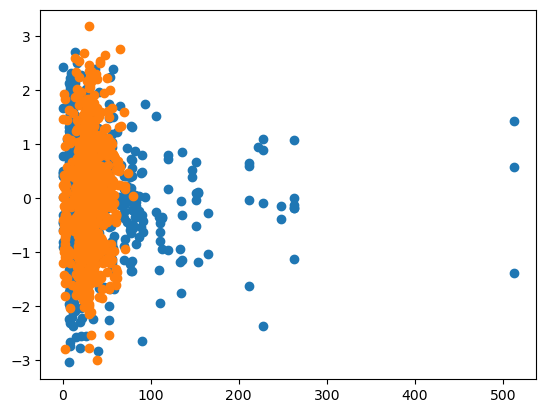

In [4]:
np.random.seed(0)

f = np.random.randn(len(training_data['Fare']))
plt.scatter(training_data['Fare'],f)

z = np.random.randn(len(training_data['Age']))
plt.scatter(training_data['Age'],z)

plt.show()

# age is clean but there is many outliers in (Fare) !!

In [5]:
print(training_data[training_data['Fare']>200].shape)

#20 OUTLIER

(20, 8)


# I'M GONNA DROP THESE ROWS 🗑️🗑️

In [6]:
training_data = training_data[training_data['Fare']<200]
print(training_data.shape)

(869, 8)


# MANIPULATING DATA
Columns SEX and EMPARKED need to be changed

In [7]:
#CHANGING THE SEX CATEGORIES FROM MALEs AND FEMALEs TO 1s AND 0s
training_data['Sex'] = training_data['Sex'].replace({'male': 1, 'female': 0})

print(training_data.head())

#DETERMINING HOW MANY CATEGRIES IN EMBARKED

print(training_data["Embarked"].nunique())

print(training_data["Embarked"].unique())



   Pclass  Sex   Age  SibSp  Parch     Fare Embarked  Survived
0       3    1  22.0      1      0   7.2500        S         0
1       1    0  38.0      1      0  71.2833        C         1
2       3    0  26.0      0      0   7.9250        S         1
3       1    0  35.0      1      0  53.1000        S         1
4       3    1  35.0      0      0   8.0500        S         0
3
['S' 'C' 'Q']


Now we know that we have 3 Categorries ['S','C','Q'] \
WE MARK \
        'S' AS 0 \
        'C' AS 1  
        'Q' AS 2 

In [8]:
training_data['Embarked'] = training_data['Embarked'].map({'S': 0, 'C': 1, 'Q':2})
print(training_data.head())

   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Survived
0       3    1  22.0      1      0   7.2500         0         0
1       1    0  38.0      1      0  71.2833         1         1
2       3    0  26.0      0      0   7.9250         0         1
3       1    0  35.0      1      0  53.1000         0         1
4       3    1  35.0      0      0   8.0500         0         0


Splitting

In [9]:
x = training_data[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']].values
y = training_data['Survived'].values


x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=21, stratify=y)
scaler = StandardScaler()
x_train_scaled =  scaler.fit_transform(x_train)
x_test_scaled =  scaler.transform(x_test)
x_train = x_train_scaled
x_test = x_test_scaled


# NOW for the KNN

In [10]:

knn = knc(n_neighbors = 9)
knn.fit(x_train,y_train)
print(knn.score(x_test,y_test))





0.7873563218390804


VERY BAD SCORE \
LET ME IMPROVE IT

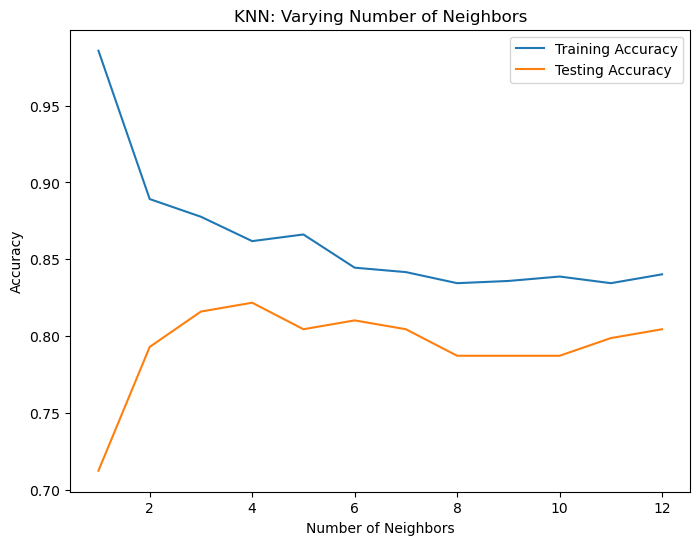

In [11]:
train_accuracies = {}
test_accuracies = {}
neighbors = np.arange(1,13)

for neighbor in neighbors:
    knn = knc(n_neighbors=neighbor)
    knn.fit(x_train,y_train)
    train_accuracies[neighbor] = knn.score(x_train,y_train)
    test_accuracies[neighbor] = knn.score(x_test,y_test)

# WE PLOT THE DATA TO GET THE BEST NUMBER OF NEIGHBORS

plt.figure(figsize=(8, 6))
plt.title("KNN: Varying Number of Neighbors")
plt.plot(neighbors, train_accuracies.values(), label="Training Accuracy")
plt.plot(neighbors, test_accuracies.values(), label="Testing Accuracy")
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()


The best number of neighbors is 2 according to the plot

In [12]:

knn = knc(n_neighbors = 4)
knn.fit(x_train,y_train)
knn_accuracy = knn.score(x_test,y_test)

print('testing accuracy: '+str( knn.score(x_test,y_test)))
print('training accuracy: '+str(knn.score(x_train,y_train)))

testing accuracy: 0.8218390804597702
training accuracy: 0.8618705035971223


# The Accuracy and classification report

In [13]:

y_pred = knn.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[99 10]
 [21 44]]
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       109
           1       0.81      0.68      0.74        65

    accuracy                           0.82       174
   macro avg       0.82      0.79      0.80       174
weighted avg       0.82      0.82      0.82       174



# NOW FOR THE NAIVE BAYS

In [14]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
gnb_accuracy = gnb.score(x_test,y_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[88 21]
 [17 48]]
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       109
           1       0.70      0.74      0.72        65

    accuracy                           0.78       174
   macro avg       0.77      0.77      0.77       174
weighted avg       0.78      0.78      0.78       174



# linear support vector machine

In [15]:
svm_model = SVC(kernel = 'linear')
svm_model.fit(x_train,y_train)
y_pred = svm_model.predict(x_test)
svm_model_accuracy = svm_model.score(x_test,y_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[93 16]
 [22 43]]
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       109
           1       0.73      0.66      0.69        65

    accuracy                           0.78       174
   macro avg       0.77      0.76      0.76       174
weighted avg       0.78      0.78      0.78       174



different kernel function

In [16]:
svm = SVC(kernel = 'rbf', gamma=0.1)
svm.fit(x_train,y_train)
svm_rbf_accuracy = svm.score(x_test,y_test)
y_pred = svm.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       109
           1       0.76      0.65      0.70        65

    accuracy                           0.79       174
   macro avg       0.79      0.76      0.77       174
weighted avg       0.79      0.79      0.79       174



# Comparitave analysis: 

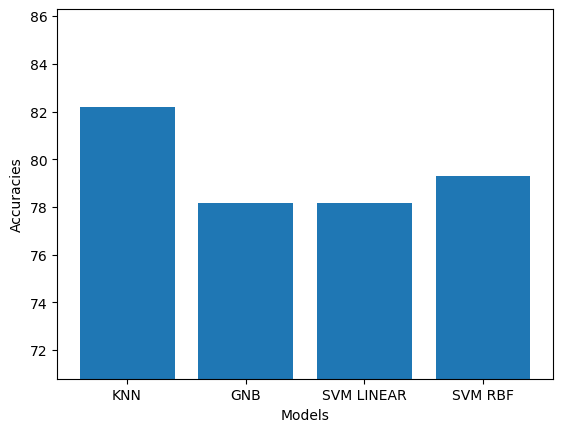

In [17]:
models = ['KNN','GNB','SVM LINEAR','SVM RBF']
accuracies = [knn_accuracy*100,gnb_accuracy*100,svm_model_accuracy*100,svm_rbf_accuracy*100]

plt.bar(models,accuracies)
plt.xlabel('Models')
plt.ylabel('Accuracies')
plt.ylim(70.80)

plt.show()

## CONCLUSION : the highest accuracy on this model is the KNN

# performing pre-processing on test file

In [18]:
testing = pd.read_csv('test.csv')
testing = testing.drop(['PassengerId','Cabin','Name','Ticket'],axis=1)

#calculating the mean 
mean_of_age = testing['Age'].mean()



#filling the Age column with the mean
testing['Age'] = testing['Age'].fillna(mean_of_age)

#droping the missng rows
testing = testing.dropna()


print(testing.isna().sum()) #--> no missing values 

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


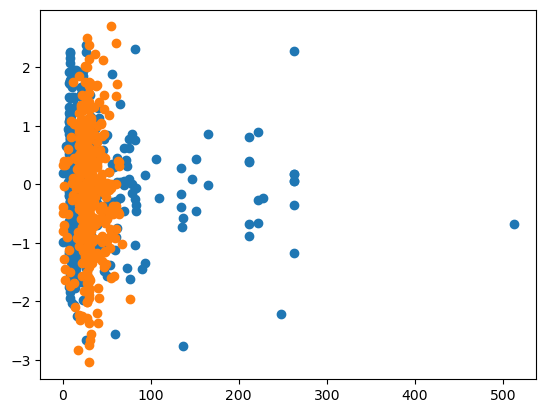

In [19]:
np.random.seed(0)

f = np.random.randn(len(testing['Fare']))
plt.scatter(testing['Fare'],f)

z = np.random.randn(len(testing['Age']))
plt.scatter(testing['Age'],z)

plt.show()

dropping anything above 110

In [20]:
testing = testing[testing['Fare']<110]
print(testing.shape)

(388, 7)


In [21]:
#CHANGING THE SEX CATEGORIES FROM MALEs AND FEMALEs TO 1s AND 0s
testing['Sex'] = testing['Sex'].replace({'male': 1, 'female': 0})

print(testing.head())

#DETERMINING HOW MANY CATEGRIES IN EMBARKED

print(testing["Embarked"].nunique())

print(testing["Embarked"].unique())


   Pclass  Sex   Age  SibSp  Parch     Fare Embarked
0       3    1  34.5      0      0   7.8292        Q
1       3    0  47.0      1      0   7.0000        S
2       2    1  62.0      0      0   9.6875        Q
3       3    1  27.0      0      0   8.6625        S
4       3    0  22.0      1      1  12.2875        S
3
['Q' 'S' 'C']


In [22]:
testing['Embarked'] = testing['Embarked'].map({'S': 0, 'C': 1, 'Q':2})
print(testing.head())
x_test_scaled =  scaler.transform(testing)
testing = x_test_scaled


   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0       3    1  34.5      0      0   7.8292         2
1       3    0  47.0      1      0   7.0000         0
2       2    1  62.0      0      0   9.6875         2
3       3    1  27.0      0      0   8.6625         0
4       3    0  22.0      1      1  12.2875         0


c:\Users\sxlei\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [23]:
knn = knc(n_neighbors = 4)
knn.fit(x_train,y_train)

y_pred = knn.predict(testing)
len(y_pred) == len(testing)
#testing = testing.assign(Survived=y_pred)
#print(testing['Survived'].unique())
#print(testing.head())


True

In [523]:
y_pred = pd.DataFrame()

# #print(testing.head())
# print(testing['Survived'].nunique())
# print(testing['Survived'].value_counts())
